# Logistic Regression Pipeline for K562 (GREG)

### Author: Shaurya Jauhari (Mora Lab)
### Contact: Antonio Mora (antoniocmora@gzhmu.edu.cn)
### Last Reviewed : Dec. 9th, 2020

## Prologue

This notebook assesses variegated implementations of the logistic regression models for the data derived from the K562 cell-line in GREG. The data for this and other cell-types for GREG is available at this <a href = "https://zenodo.org/record/6339915"> link</a>. The current notebook uses the file "K562forML.txt".

## Contents

* [1. Loading Packages](#link1)
* [2. Loading Data](#link2)
* [3. Building Model](#link3)
* [4. Dealing with the *Paradox* of Accuracy ](#link4)
    * [4.1 Problem of Class Imbalance](#link5)
        * [4.1.1 Oversampling of minority class](#link6)
        * [4.1.2 Undersampling of minority class](#link7)
        * [4.1.3 SMOTE](#link8)
        * [4.1.4 Both over- and under-sampling](#link9)
* [5. Ratifying the *Pareto's Principle*](#link10)
    * [5.1 SMOTE data](#link11)
* [6. Visualizing Predictions](#link12)
* [7. Session Information](#link13)

### <a id=link1>1. Loading Packages </a>

In [1]:
requiredPackages <- c("glmnet", "rms", "caret", "e1071", "ROSE", "DMwR", "BiocManager", "ROCR")
newPackages <- requiredPackages[!(requiredPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages, dependencies = TRUE)

suppressPackageStartupMessages(library(glmnet))
suppressPackageStartupMessages(library(rms))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(e1071))
suppressPackageStartupMessages(library(ROSE))
suppressPackageStartupMessages(library(DMwR))
suppressPackageStartupMessages(library(ROCR))

### <a id=link2>2. Loading Data </a>

In [2]:
k562gregStandard <- read.table("K562forML.txt", header = TRUE) ## loading full data
k562greg <- k562gregStandard[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [58]:
head(k562greg)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,RNAPol3,YY1,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00000,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.0000000,0.00000,0.0000000,0
2,0.00000,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.0000000,0.00000,0.0000000,0
3,0.00000,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.0000000,0.00000,0.0000000,0
4,0.00000,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.0000000,0.00000,0.0000000,0
5,0.00000,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.0000000,0.00000,0.0000000,0
6,47.61676,0.0274939,0.8087214,1.045595,0.7726153,1.202883,1.627348,1.188197,6.28546,8.497575,0,0.1668389,20.66886,0.1562263,0


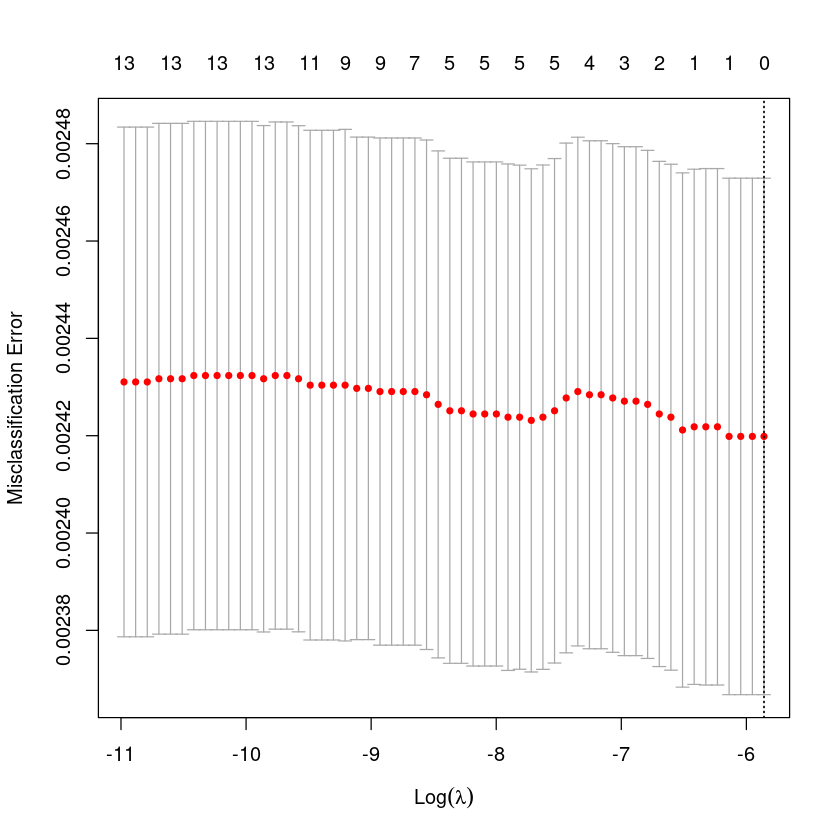

In [4]:
set.seed(005)
cv.modelfit <- cv.glmnet(as.matrix(k562greg[,1:14]),
                         k562greg$Class,
                         family = "binomial",
                         type.measure = "class",
                         alpha = 1,
                         nlambda = 100)


plot(cv.modelfit)

In [5]:
cat("There are", length(cv.modelfit$lambda),
    "lambda values in all:\n",
    cv.modelfit$lambda,
    "\n, out of which",
    min(cv.modelfit$lambda),
    "is the minimum, while",
    cv.modelfit$lambda.1se,
    "denotes the value at which the model is optimized at one standard error.")

There are 56 lambda values in all:
 0.002853877 0.002600347 0.002369339 0.002158853 0.001967067 0.001792318 0.001633093 0.001488014 0.001355823 0.001235375 0.001125628 0.00102563 0.0009345161 0.0008514962 0.0007758517 0.0007069271 0.0006441257 0.0005869033 0.0005347645 0.0004872575 0.0004439709 0.0004045297 0.0003685924 0.0003358477 0.0003060119 0.0002788266 0.0002540564 0.0002314868 0.0002109221 0.0001921844 0.0001751113 0.0001595549 0.0001453804 0.0001324652 0.0001206974 0.000109975 0.0001002051 9.130315e-05 8.319203e-05 7.580148e-05 6.906749e-05 6.293172e-05 5.734104e-05 5.224702e-05 4.760554e-05 4.337639e-05 3.952295e-05 3.601184e-05 3.281265e-05 2.989767e-05 2.724164e-05 2.482157e-05 2.261649e-05 2.06073e-05 1.877661e-05 1.710854e-05 
, out of which 1.710854e-05 is the minimum, while 0.002853877 denotes the value at which the model is optimized at one standard error.

### <a id=link3>3. Building Model </a>

In [6]:
set.seed(2)
modelfit <- glmnet(as.matrix(k562greg[,1:14]),
                   k562greg$Class,
                   family = "binomial",
                   alpha = 1,
                   lambda = cv.modelfit$lambda)

# Listing non-zero coefficients
print(modelfit$beta[,1])

         CTCF         EP300      H3K27me3      H3K36me3       H3K4me1 
 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
      H3K4me2       H3K4me3        H3K9ac       H3K9me3         RAD21 
 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
      RNA.Seq       RNAPol2       RNAPol3           YY1 
 0.000000e+00 -3.123273e-16  0.000000e+00  0.000000e+00 


In [7]:
coef(modelfit)[,1]
predict(modelfit, type="coef")

(Intercept)          CTCF         EP300      H3K27me3      H3K36me3 
 6.021623e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
      H3K4me1       H3K4me2       H3K4me3        H3K9ac       H3K9me3 
 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 
        RAD21       RNA.Seq       RNAPol2       RNAPol3           YY1 
 0.000000e+00  0.000000e+00 -3.123273e-16  0.000000e+00  0.000000e+00

   [[ suppressing 56 column names ‘s0’, ‘s1’, ‘s2’ ... ]]



15 x 56 sparse Matrix of class "dgCMatrix"
                                                                         
(Intercept)  6.021623e+00  6.03775478  6.04620156  6.05226594  6.05720879
CTCF         .             .           .           .           .         
EP300        .             .           .           .           .         
H3K27me3     .             .           .           .           .         
H3K36me3     .             .           .           .           .         
H3K4me1      .             .           .           .           .         
H3K4me2      .             .           .           .           .         
H3K4me3      .             .           .           .           .         
H3K9ac       .             .           .           .           .         
H3K9me3      .             .           .           .           .         
RAD21        .             .           .           .           .         
RNA.Seq      .             .           .           .           .     

In [8]:
set.seed(5) # for reproducibility of results.

# branding class labels as factors
k562greg$Class <- as.numeric(as.factor(k562greg$Class))

# '1' for Hubs and '0' for Non-Hubs 
k562greg$Class <- ifelse(k562greg$Class == 2, 0, 1)

part <- sample(2, nrow(k562greg),
               replace = TRUE,
               prob = c(0.7,0.3))
train <- k562greg[part==1,]
test <- k562greg[part==2,]
cat("So, now we have",
    nrow(train),
    "training rows and",
    nrow(test),
    "testing rows")

k562model <- glm(formula = Class ~ .,
               data = train,
               family = "binomial")
summary(k562model)

So, now we have 1064061 training rows and 455449 testing rows

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6203  -0.0675  -0.0648  -0.0636   3.9458  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -6.203288   0.024847 -249.656  < 2e-16 ***
CTCF        -0.001679   0.009982   -0.168 0.866449    
EP300        0.043000   0.011953    3.597 0.000322 ***
H3K27me3     0.100968   0.019449    5.191 2.09e-07 ***
H3K36me3     0.033262   0.016424    2.025 0.042850 *  
H3K4me1      0.087436   0.009969    8.771  < 2e-16 ***
H3K4me2     -0.017110   0.012686   -1.349 0.177404    
H3K4me3     -0.019295   0.018290   -1.055 0.291451    
H3K9ac       0.042372   0.007995    5.300 1.16e-07 ***
H3K9me3     -0.011303   0.007914   -1.428 0.153195    
RAD21       -0.115301   0.017095   -6.745 1.53e-11 ***
RNA.Seq     -0.003138   0.002339   -1.342 0.179676    
RNAPol2      0.045618   0.002731   16.701  < 2e-16 ***
RNAPol3      0.002752   0.001010  

In [9]:
vif(k562model)

CTCF      EP300   H3K27me3   H3K36me3    H3K4me1    H3K4me2    H3K4me3 
 36.864211   2.580361 105.452483  63.121914  11.920563  36.911295 113.796343 
    H3K9ac    H3K9me3      RAD21    RNA.Seq    RNAPol2    RNAPol3        YY1 
 24.629977   1.381496 209.098184   1.113516   2.833112   1.402665   1.972098

<b>CTCF</b>, <b>H3K4me2</b>, and <b>H3K4me3</b> are the variables with no statistical significance, and high variance inflation factor value. We shall omit them and re-evaluate the model. 

In [10]:
k562model1 <- glm(formula = Class ~ EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3 + YY1,
               data = train,
               family = "binomial")
summary(k562model1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3 + 
    YY1, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5711  -0.0673  -0.0648  -0.0635   3.9287  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -6.2066163  0.0247130 -251.147  < 2e-16 ***
EP300        0.0529261  0.0115831    4.569 4.89e-06 ***
H3K27me3     0.0977202  0.0189834    5.148 2.64e-07 ***
H3K36me3     0.0353079  0.0156626    2.254   0.0242 *  
H3K4me1      0.0750311  0.0087559    8.569  < 2e-16 ***
H3K9ac       0.0161967  0.0038759    4.179 2.93e-05 ***
H3K9me3     -0.0117655  0.0059362   -1.982   0.0475 *  
RAD21       -0.1147246  0.0134702   -8.517  < 2e-16 ***
RNA.Seq     -0.0034010  0.0023779   -1.430   0.1526    
RNAPol2      0.0449132  0.0025992   17.280  < 2e-16 ***
RNAPol3      0.0021496  0.0009983    2.153   0.0313 *  
YY1         -0.0523897 

In [11]:
vif(k562model1)

EP300   H3K27me3   H3K36me3    H3K4me1     H3K9ac    H3K9me3      RAD21 
  2.429824  92.653328  53.090126   8.560988   5.778671   1.363264 118.945508 
   RNA.Seq    RNAPol2    RNAPol3        YY1 
  1.105743   2.566086   1.337723   1.955944

In [12]:
yTrain <- predict(k562model1, train, type = "response")
head(yTrain)

1           2           4           5           7          10 
0.002011991 0.002011991 0.002011991 0.002011991 0.002641744 0.001990640

In [13]:
head(train)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,RNAPol3,YY1,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.000000,0,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.0000000,0.00000000,0,0.0000000,0,0
2,0.000000,0,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.0000000,0.00000000,0,0.0000000,0,0
4,0.000000,0,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.0000000,0.00000000,0,0.0000000,0,0
5,0.000000,0,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.0000000,0.00000000,0,0.0000000,0,0
7,1.846856,0,0.9300297,2.533556,3.3112083,1.6483952,0.8950416,1.4451047,4.858491,1.0692313,0.05683756,0,0.3636749,0,0
10,1.084024,0,0.5661050,3.217214,0.8461977,0.5791659,0.7323068,0.6743822,1.223117,0.9004053,40.46833918,0,0.6061248,0,0


The confusion matrix is
         Actual
Predicted       0       1
        0 1061510    2514
        1      24      13
The accuracy of the model is 99.76148 % 
The misclassification error of the model is 0.2385202 % 
The sensitivity of the model is 99.99774 % 
The specificity of the model is 0.514444 % 
The area under curve is 0.5025609 
The statistical significance for the model is 4.830499e-205 
The confidence level for the model is 100 %

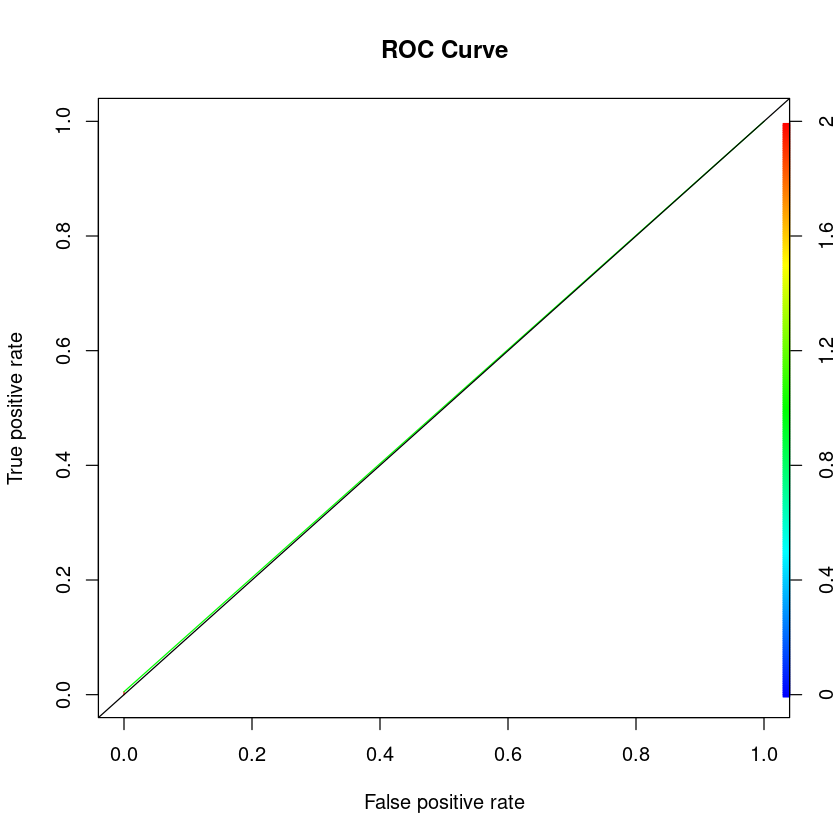

In [14]:
source("../../transcriptionFactoriesGREG/MachineLearning/R/modelPerformance.R")
modelPerformance(k562model1, "LR", train, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0 454290   1144
        1      9      6
The accuracy of the model is 99.74684 % 
The misclassification error of the model is 0.2531568 % 
The sensitivity of the model is 99.99802 % 
The specificity of the model is 0.5217391 % 
The area under curve is 0.5025988 
The statistical significance for the model is 4.830499e-205 
The confidence level for the model is 100 %

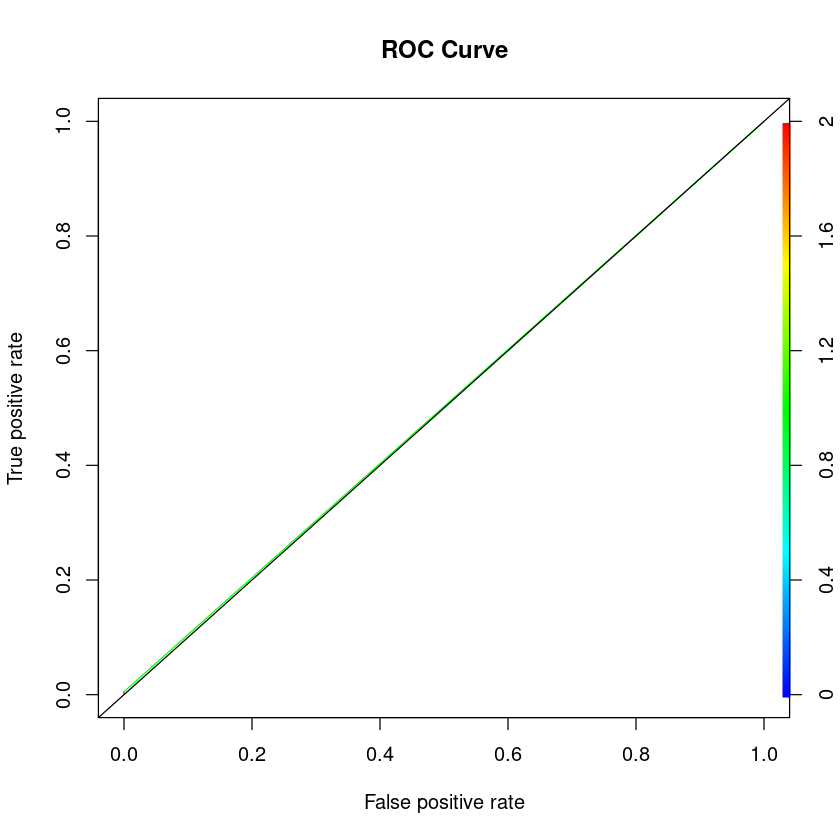

In [15]:
modelPerformance(k562model1, "lr", test, Class)

We can clearly observe that the model has **high sensitivity** and **zero specificity**. It means that the model is highly biased towards the non-hubs and that solely accounts for the data imbalance.

### <a id=link4>4. Dealing with the *Paradox* of Accuracy  </a>

The model is highly accurate in predicting the non-hubs individually. Since the data carries significant imbalance in the classes (non-hubs are far more in number than the hubs), the prediction for the hubs might not be well suited. We need to extend the analysis for a "balanced" data. But before we delve further, let us calculate the sensitivity and specificity parameters to check how well the model is able to identify positive class labels (0: hubs).

This is clearly not what we want.

####  <a id=link5>4.1 Problem of Class Imbalance </a>

The problem of class imbalance presents a warranting scenario for data normalization in terms of class proportions. Two simple strategies to mitigate this problem are oversampling and undersampling.

#####  <a id=link5> 4.1.1 Oversampling of minority class </a>

In [16]:
table(k562greg$Class)


      0       1 
1515833    3677 

We can articulate that the hubs(class marked with '0') are way less than the non-hubs. To scale them in proportion to the non-hubs, we can choose to oversample their instances. This is carried out by randomly choosing their exisiting data points and repeating to match a specified number. The package ***ROSE*** comes in handy here. The details about the package could be found [here](https://www.rdocumentation.org/packages/ROSE/versions/0.0-3).

In [17]:
overTrain <- ovun.sample(Class ~., data = train, method = "over", N = 1515833)$data

In [18]:
table(overTrain$Class)


      0       1 
1061534  454299 

Still better. Let's run the model again to see if there is any improvement in the performance.

In [19]:
k562modelOver <- glm(formula = Class ~ .,
               data = overTrain,
               family = "binomial")
summary(k562modelOver)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = overTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -0.7904  -0.6881   1.1886   2.0485  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.5842621  0.0036074 -439.17  < 2e-16 ***
CTCF        -0.0219341  0.0014770  -14.85  < 2e-16 ***
EP300       -0.0628583  0.0023536  -26.71  < 2e-16 ***
H3K27me3     0.3838733  0.0026354  145.66  < 2e-16 ***
H3K36me3     0.2072996  0.0021884   94.73  < 2e-16 ***
H3K4me1      0.1743959  0.0016646  104.77  < 2e-16 ***
H3K4me2     -0.1417790  0.0028300  -50.10  < 2e-16 ***
H3K4me3      0.0470963  0.0033222   14.18  < 2e-16 ***
H3K9ac       0.1256631  0.0019766   63.58  < 2e-16 ***
H3K9me3      0.0085739  0.0015149    5.66 1.52e-08 ***
RAD21        0.1302145  0.0037281   34.93  < 2e-16 ***
RNA.Seq     -0.0051830  0.0002902  -17.86  < 2e-16 ***
RNAPol2      0.0307730  0.0007080   43.47  < 2e-16 ***
RNAPol3      0.0104946  0.0002

The confusion matrix is
         Actual
Predicted      0      1
        0 437961    966
        1  16338    184
The accuracy of the model is 96.20067 % 
The misclassification error of the model is 3.799328 % 
The sensitivity of the model is 96.40369 % 
The specificity of the model is 16 % 
The area under curve is 0.5620185 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

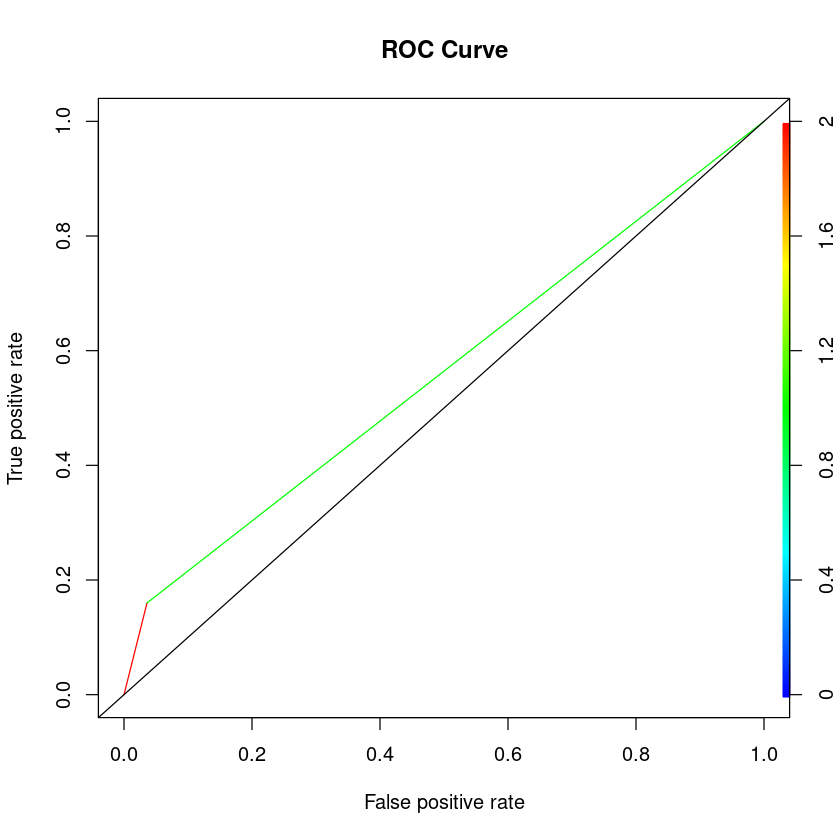

In [20]:
modelPerformance(k562modelOver, "LR", test, Class)

This is better than before but still not good enough. Maybe we can try the other approach.

##### <a id=link5> 4.1.2 Undersampling of majority class  </a>

Contrary to what we did above, we shall now scale down the random data points from the majority class and see if the model performs any better.

In [21]:
underTrain <- ovun.sample(Class ~., data = train, method = "under", N= 5000)$data
table(underTrain$Class)


   0    1 
2473 2527 

In [22]:
k562modelUnder <- glm(formula = Class ~ .,
               data = underTrain,
               family = "binomial")
summary(k562modelUnder)


Call:
glm(formula = Class ~ ., family = "binomial", data = underTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.2508  -1.0304   0.0562   1.1335   1.8361  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.1421020  0.0679442 -16.809  < 2e-16 ***
CTCF        -0.1447421  0.0289610  -4.998 5.80e-07 ***
EP300       -0.0923119  0.0354127  -2.607 0.009141 ** 
H3K27me3     0.3833579  0.0466045   8.226  < 2e-16 ***
H3K36me3     0.2124340  0.0402238   5.281 1.28e-07 ***
H3K4me1      0.1992399  0.0319704   6.232 4.60e-10 ***
H3K4me2     -0.1778887  0.0512513  -3.471 0.000519 ***
H3K4me3      0.1017103  0.0539691   1.885 0.059484 .  
H3K9ac       0.0818126  0.0323775   2.527 0.011510 *  
H3K9me3      0.0279688  0.0266697   1.049 0.294311    
RAD21        0.8217624  0.0985918   8.335  < 2e-16 ***
RNA.Seq     -0.0009999  0.0064388  -0.155 0.876593    
RNAPol2      0.0437742  0.0140597   3.113 0.001849 ** 
RNAPol3     -0.0004777  0.001

In [23]:
vif(k562modelUnder)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
 2.170904  2.203779  1.253842  1.442217  1.977484 29.090104 20.407571 11.241768 
  H3K9me3     RAD21   RNA.Seq   RNAPol2   RNAPol3       YY1 
 1.152549  2.393555  1.140381  2.931624  1.337532  1.704314

We can chuck-off **H3K4me3** for having high values for *p* and VIF.  

In [24]:
k562modelUnder1 <- glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + H3K4me2 + H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3 + YY1,
               data = underTrain,
               family = "binomial")
summary(k562modelUnder1)


Call:
glm(formula = Class ~ CTCF + EP300 + H3K27me3 + H3K36me3 + H3K4me1 + 
    H3K4me2 + H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + 
    RNAPol3 + YY1, family = "binomial", data = underTrain)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-3.11853  -1.03182   0.07223   1.13360   1.77365  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.1365780  0.0678656 -16.747  < 2e-16 ***
CTCF        -0.1491964  0.0287276  -5.193 2.06e-07 ***
EP300       -0.0920370  0.0365503  -2.518 0.011799 *  
H3K27me3     0.3812501  0.0465239   8.195 2.51e-16 ***
H3K36me3     0.2235889  0.0397755   5.621 1.90e-08 ***
H3K4me1      0.1852887  0.0310775   5.962 2.49e-09 ***
H3K4me2     -0.1011896  0.0293804  -3.444 0.000573 ***
H3K9ac       0.0906259  0.0316654   2.862 0.004210 ** 
H3K9me3      0.0329205  0.0265468   1.240 0.214941    
RAD21        0.8418756  0.0981042   8.581  < 2e-16 ***
RNA.Seq     -0.0012895  0.0064265  -0.201 0.840966    
RNA

In [25]:
vif(k562modelUnder1)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2    H3K9ac   H3K9me3 
 2.153238  2.169087  1.249564  1.409214  1.848152  9.700487 10.826751  1.142064 
    RAD21   RNA.Seq   RNAPol2   RNAPol3       YY1 
 2.363231  1.138776  2.817818  1.326202  1.718691

The confusion matrix is
         Actual
Predicted      0      1
        0 327943    512
        1 126356    638
The accuracy of the model is 72.14441 % 
The misclassification error of the model is 27.85559 % 
The sensitivity of the model is 72.1866 % 
The specificity of the model is 55.47826 % 
The area under curve is 0.6383243 
The statistical significance for the model is 5.807956e-138 
The confidence level for the model is 100 %

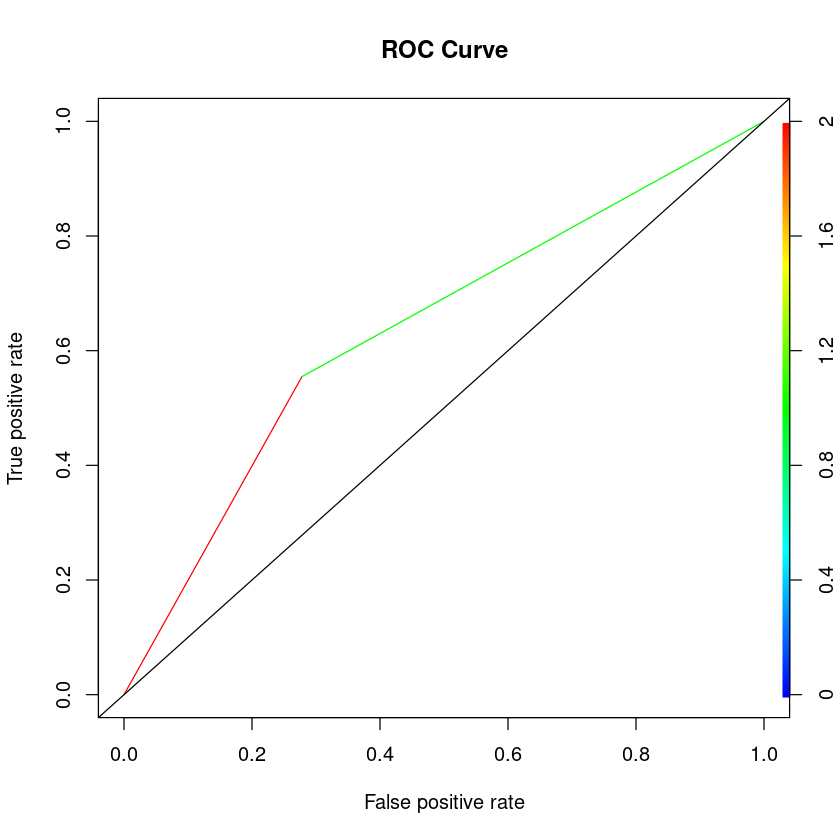

In [26]:
modelPerformance(k562modelUnder1, "lr", test, Class)

This case is somewhat balanced, not only in terms of respective data points but also sensivitiy and specificity of the classifier.

##### <a id=link8> 4.1.3 SMOTE  </a>

The sampling techniques are straighforward, but could possibly engender a classifier that overfits the training data and hence might not be suitable for a general application. To handle such a chance, [SMOTE](https://www3.nd.edu/~dial/publications/chawla2002smote.pdf) was introduced by Chawla et al. in 2002 and the functionality is available in R with the package *DMwR*.

In [27]:
table(k562greg$Class)


      0       1 
1515833    3677 

In [28]:
## Smote : Synthetic Minority Oversampling Technique
## A pre-requisite is that the class variable in the data must be of "factor" category. Let's do that conversion.

train$Class <- as.factor(train$Class)

smoteData <- SMOTE(Class ~., train, perc.over = 5000, k = 5, perc.under = 102)

table(smoteData$Class)


     0      1 
128877 128877 

Co-incidentally, same proportion of classes are engendered.

In [29]:
k562modelSMOTE <- glm(formula = Class ~ .,
                    data = smoteData,
                    family = "binomial")
summary(k562modelSMOTE)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = smoteData)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -1.0262   0.0014   1.1576   1.8447  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.8886624  0.0085614 -103.799  < 2e-16 ***
CTCF        -0.0443996  0.0037202  -11.935  < 2e-16 ***
EP300       -0.1442870  0.0062210  -23.193  < 2e-16 ***
H3K27me3     0.4571181  0.0064377   71.006  < 2e-16 ***
H3K36me3     0.2677025  0.0056007   47.798  < 2e-16 ***
H3K4me1      0.2231773  0.0045738   48.794  < 2e-16 ***
H3K4me2     -0.2126650  0.0081699  -26.030  < 2e-16 ***
H3K4me3      0.0779222  0.0092428    8.431  < 2e-16 ***
H3K9ac       0.1879821  0.0058293   32.248  < 2e-16 ***
H3K9me3      0.0197667  0.0035910    5.504  3.7e-08 ***
RAD21        0.2290652  0.0101622   22.541  < 2e-16 ***
RNA.Seq     -0.0098247  0.0007715  -12.734  < 2e-16 ***
RNAPol2      0.0250259  0.0020010   12.507  < 2e-16 ***
RNAPol3      0.0

In [30]:
vif(k562modelSMOTE)

CTCF     EP300  H3K27me3  H3K36me3   H3K4me1   H3K4me2   H3K4me3    H3K9ac 
 2.508835  2.550388  1.174075  1.444590  2.150031 28.509473 23.489720 12.272909 
  H3K9me3     RAD21   RNA.Seq   RNAPol2   RNAPol3       YY1 
 1.169241  2.653483  1.142932  2.821108  1.219365  1.480201

All is well. Let us now examine this model with the test data.

The confusion matrix is
         Actual
Predicted      0      1
        0 339527    560
        1 114772    590
The accuracy of the model is 74.6773 % 
The misclassification error of the model is 25.3227 % 
The sensitivity of the model is 74.73646 % 
The specificity of the model is 51.30435 % 
The area under curve is 0.630204 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

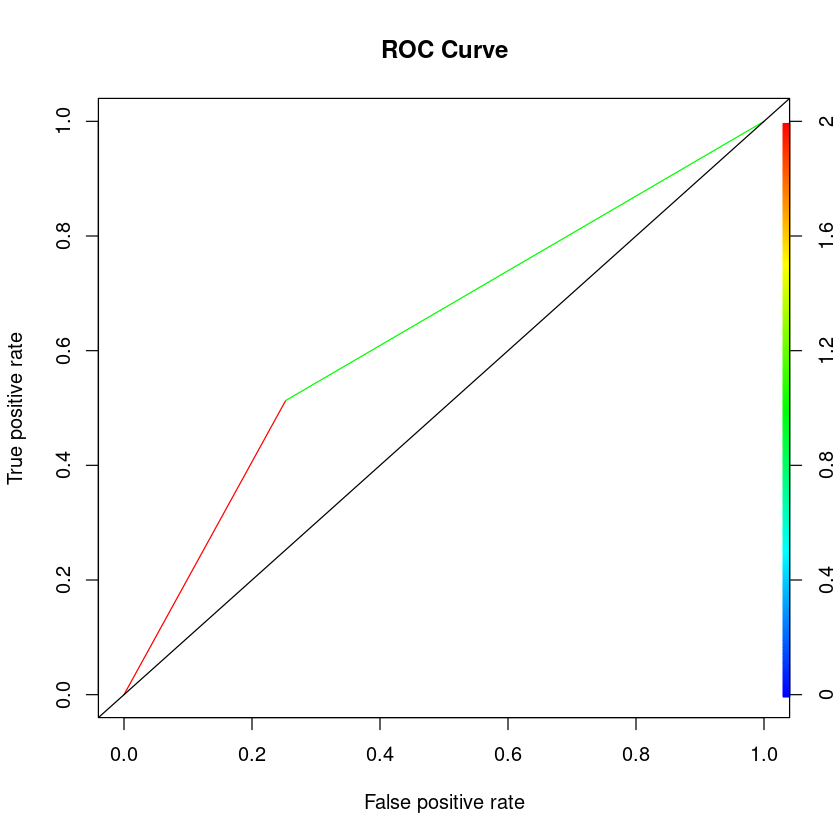

In [31]:
modelPerformance(k562modelSMOTE, "LR", test, Class)

##### <a id=link9> 4.1.4 Both over- and under-sampling </a>

This model has slightly better specificity than the previous model. In tandem, we could also try yet another flavor of the *ovun.sample()* function - to have under- and over-sampling both in parallel. This could be a likely run like the SMOTE as above.

In [32]:
bothTrain <- ovun.sample(Class ~., data = train, method = "both", N= 1515833)$data
table(bothTrain$Class)


     0      1 
757854 757979 

In [33]:
k562modelBoth <- glm(formula = Class ~ .,
               data = bothTrain,
               family = "binomial")
summary(k562modelBoth)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = bothTrain)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -1.0253   0.0058   1.1556   1.7855  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -0.9245172  0.0035722 -258.811  < 2e-16 ***
CTCF        -0.0574093  0.0014926  -38.463  < 2e-16 ***
EP300       -0.1107992  0.0022871  -48.446  < 2e-16 ***
H3K27me3     0.4427600  0.0026420  167.585  < 2e-16 ***
H3K36me3     0.2599904  0.0022697  114.551  < 2e-16 ***
H3K4me1      0.2054131  0.0018056  113.762  < 2e-16 ***
H3K4me2     -0.1698369  0.0030173  -56.289  < 2e-16 ***
H3K4me3      0.0601004  0.0034751   17.294  < 2e-16 ***
H3K9ac       0.1510056  0.0021636   69.793  < 2e-16 ***
H3K9me3      0.0098168  0.0014575    6.735 1.64e-11 ***
RAD21        0.2927839  0.0042521   68.856  < 2e-16 ***
RNA.Seq     -0.0067852  0.0003022  -22.453  < 2e-16 ***
RNAPol2      0.0281897  0.0007717   36.528  < 2e-16 ***
RNAPol3      0.0

The confusion matrix is
         Actual
Predicted      0      1
        0 339752    545
        1 114547    605
The accuracy of the model is 74.72999 % 
The misclassification error of the model is 25.27001 % 
The sensitivity of the model is 74.78599 % 
The specificity of the model is 52.6087 % 
The area under curve is 0.6369734 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

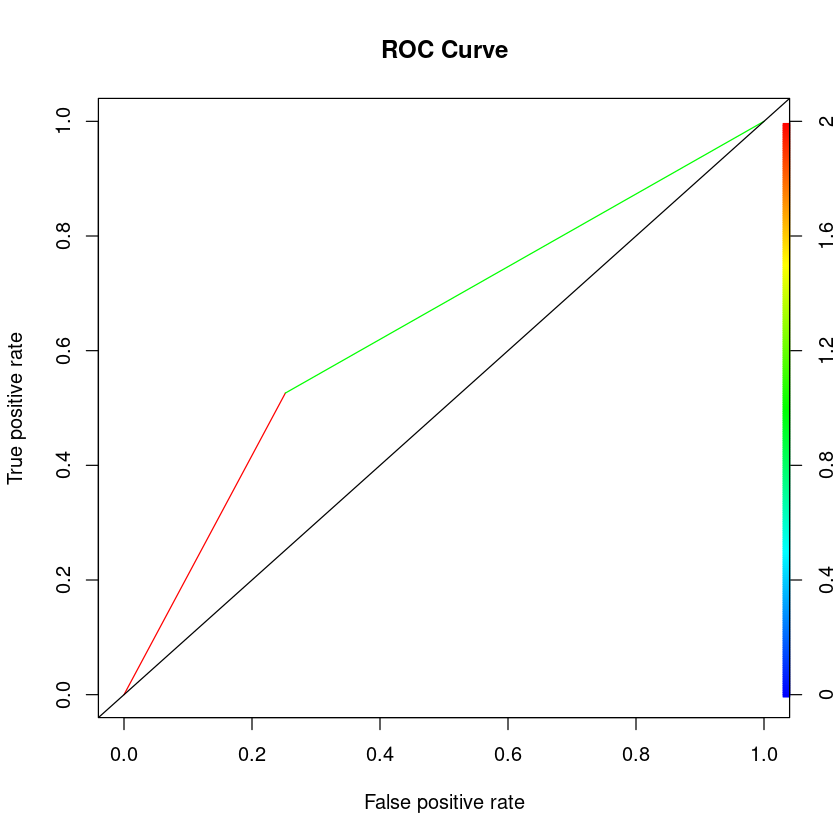

In [35]:
modelPerformance(k562modelBoth, "LR", test, Class)

These numbers are marginally better than the previous model.

### <a id=link10>5. Ratifying the *Pareto's Principle* </a>

The 80:20 rule is omnipresent in the domains of business and economy. Hardly would have the italian economist known at the time that his [theory](https://en.wikipedia.org/wiki/Pareto_principle) would be rooted deeper than his perception. 

In [36]:
set.seed(6) # for reproducibility of results.
parts <- sample(2, nrow(k562greg),
               replace = TRUE,
               prob = c(0.8,0.2))
training <- k562greg[parts==1,]
testing <- k562greg[parts==2,]
cat("So, now we have", nrow(training), "training rows and", nrow(testing), "testing rows")

So, now we have 1215728 training rows and 303782 testing rows

In [37]:
k562paretoModel <- glm(formula = Class ~ ., data = training, family = "binomial")
summary(k562paretoModel)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.9498  -0.0679  -0.0659  -0.0647   3.8111  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -6.1680185  0.0225344 -273.715  < 2e-16 ***
CTCF        -0.0030512  0.0091554   -0.333  0.73894    
EP300        0.0344865  0.0113765    3.031  0.00243 ** 
H3K27me3     0.0534575  0.0207304    2.579  0.00992 ** 
H3K36me3     0.0024049  0.0173100    0.139  0.88950    
H3K4me1      0.1003056  0.0092681   10.823  < 2e-16 ***
H3K4me2     -0.0386521  0.0131651   -2.936  0.00333 ** 
H3K4me3      0.0117776  0.0178403    0.660  0.50915    
H3K9ac       0.0369003  0.0072131    5.116 3.13e-07 ***
H3K9me3     -0.0076770  0.0057463   -1.336  0.18156    
RAD21       -0.0807859  0.0178783   -4.519 6.22e-06 ***
RNA.Seq     -0.0034119  0.0021310   -1.601  0.10936    
RNAPol2      0.0440874  0.0026431   16.680  < 2e-16 ***
RNAPol3      0.00

In [38]:
vif(k562paretoModel)

CTCF      EP300   H3K27me3   H3K36me3    H3K4me1    H3K4me2    H3K4me3 
 36.447948   2.575689 139.866065  81.880890  12.183676  43.167724 125.022483 
    H3K9ac    H3K9me3      RAD21    RNA.Seq    RNAPol2    RNAPol3        YY1 
 22.777188   2.682299 268.177484   1.145475   2.911677   1.407280   1.834410

We observe that **CTCF**, **H3K36me3**, and **H3K4me3** have high values for *p* and variance inflation factor. Let's reorient the model omitting these values. 

In [39]:
k562paretoModel1 <- glm(formula = Class ~ EP300 + H3K27me3 + H3K4me1 + H3K4me2 + H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3 + YY1, 
                        data = training, family = "binomial")
summary(k562paretoModel1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ EP300 + H3K27me3 + H3K4me1 + H3K4me2 + 
    H3K9ac + H3K9me3 + RAD21 + RNA.Seq + RNAPol2 + RNAPol3 + 
    YY1, family = "binomial", data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0238  -0.0679  -0.0659  -0.0647   3.7869  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept) -6.1675015  0.0222809 -276.807  < 2e-16 ***
EP300        0.0328754  0.0111684    2.944  0.00324 ** 
H3K27me3     0.0553798  0.0202692    2.732  0.00629 ** 
H3K4me1      0.0991358  0.0080772   12.273  < 2e-16 ***
H3K4me2     -0.0322728  0.0075925   -4.251 2.13e-05 ***
H3K9ac       0.0394013  0.0064523    6.107 1.02e-09 ***
H3K9me3     -0.0055938  0.0043788   -1.277  0.20143    
RAD21       -0.0788367  0.0132547   -5.948 2.72e-09 ***
RNA.Seq     -0.0033823  0.0020641   -1.639  0.10130    
RNAPol2      0.0441930  0.0025690   17.202  < 2e-16 ***
RNAPol3      0.0027912  0.0009204    3.033  0.00242 ** 
YY1         -0.023663

In [40]:
vif(k562paretoModel1)

EP300   H3K27me3    H3K4me1    H3K4me2     H3K9ac    H3K9me3      RAD21 
  2.475093 132.773592   9.193897  14.295519  18.160081   1.595654 146.336104 
   RNA.Seq    RNAPol2    RNAPol3        YY1 
  1.077226   2.750659   1.391861   1.811487

The confusion matrix is
         Actual
Predicted      0      1
        0 303059    709
        1      6      8
The accuracy of the model is 99.76463 % 
The misclassification error of the model is 0.2353662 % 
The sensitivity of the model is 99.99802 % 
The specificity of the model is 1.11576 % 
The area under curve is 0.5055689 
The statistical significance for the model is 1.486679e-217 
The confidence level for the model is 100 %

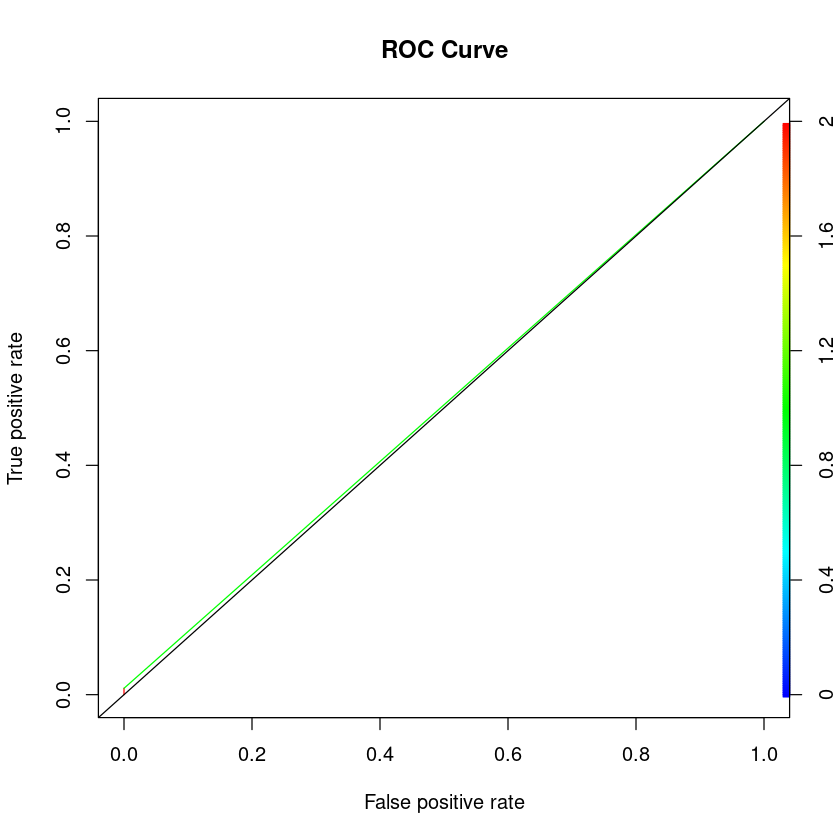

In [41]:
modelPerformance(k562paretoModel1, "lr", testing, Class)

We see here that the issue of class imbalance imposes skewness on the classifier to predict solely non-hubs (represented by "0"). The balancing of the data, as practiced above, might come to the rescue. Let's examine the performance of the classifier on SMOTE transformed data.

#### <a id=link11>5.1 SMOTE data </a>

In [42]:
table(k562greg$Class)


      0       1 
1515833    3677 

In [43]:
training$Class <- as.factor(training$Class)
smoteDatum <- SMOTE(Class ~., training, perc.over = 10000, k = 5, perc.under = 100)
table(smoteDatum$Class)


     0      1 
296000 298960 

In [44]:
k562paretoModelSmote <- glm(formula = Class ~ ., data = smoteDatum, family = "binomial")
summary(k562paretoModelSmote)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Class ~ ., family = "binomial", data = smoteDatum)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -1.0266   0.0541   1.1542   1.8596  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.9291560  0.0057532 -161.50  < 2e-16 ***
CTCF        -0.0518285  0.0024716  -20.97  < 2e-16 ***
EP300       -0.1488333  0.0041316  -36.02  < 2e-16 ***
H3K27me3     0.4616203  0.0042344  109.02  < 2e-16 ***
H3K36me3     0.2502704  0.0036826   67.96  < 2e-16 ***
H3K4me1      0.2301594  0.0029974   76.79  < 2e-16 ***
H3K4me2     -0.2258823  0.0051679  -43.71  < 2e-16 ***
H3K4me3      0.1044785  0.0059563   17.54  < 2e-16 ***
H3K9ac       0.1781888  0.0038306   46.52  < 2e-16 ***
H3K9me3      0.0264414  0.0022920   11.54  < 2e-16 ***
RAD21        0.2686509  0.0069735   38.52  < 2e-16 ***
RNA.Seq     -0.0111717  0.0005433  -20.56  < 2e-16 ***
RNAPol2      0.0222946  0.0012873   17.32  < 2e-16 ***
RNAPol3      0.0125786  0.000

The confusion matrix is
         Actual
Predicted      0      1
        0 225602    360
        1  77463    357
The accuracy of the model is 74.38196 % 
The misclassification error of the model is 25.61804 % 
The sensitivity of the model is 74.44014 % 
The specificity of the model is 49.79079 % 
The area under curve is 0.6211547 
The statistical significance for the model is 0 
The confidence level for the model is 100 %

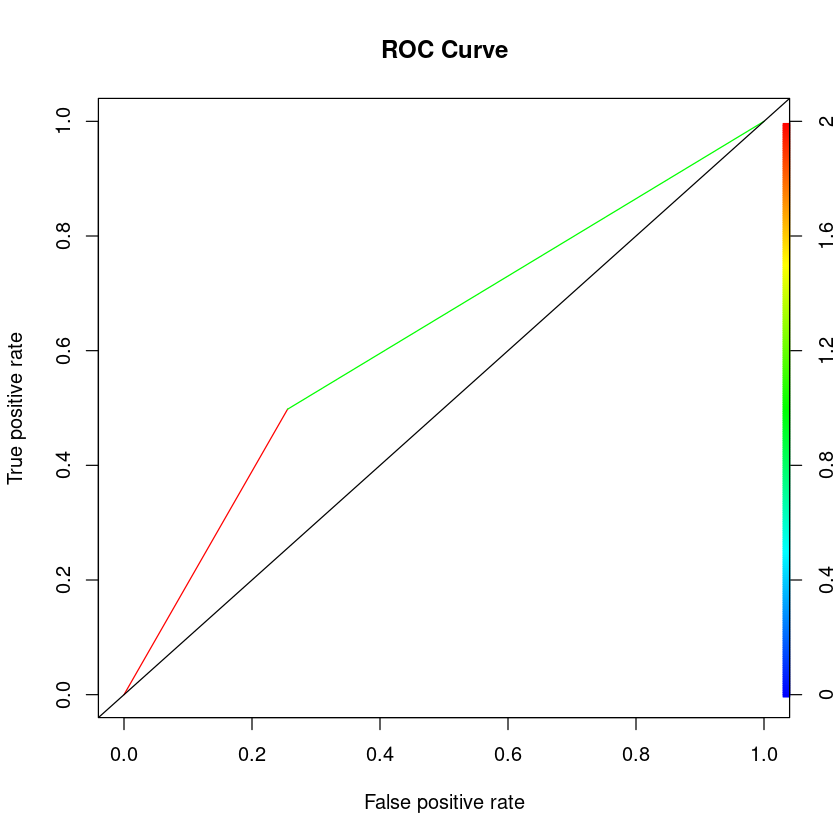

In [45]:
modelPerformance(k562paretoModelSmote, "LR", testing, Class)

### <a id=link12>6. Visualizing Predictions </a>

We choose to go with this model and will save the prediction results, that shall be later utilized for plotting.

In [46]:
k562gregModelPredictions <- predict(k562modelUnder1, k562greg, type = "response")
k562gregModelPredictionsProbs <- ifelse(k562gregModelPredictions > 0.5, 1, 0)

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the A549 cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

<a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz</a> is the package we aim to deploy for visualization.

In [47]:
if(!requireNamespace("BiocManager", quietly = TRUE))
BiocManager::install("Gviz")
suppressPackageStartupMessages(library(Gviz))

<p align="justify"> Next, we recall the data from the K562 cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need! </p>

In [48]:
k562gregStandardRegionsClass <- k562gregStandard[, c(1:3,18)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [49]:
# Extracting chr21 data

k562gregChr21NonHub <- k562gregStandardRegionsClass[k562gregStandardRegionsClass$chr=="chr21" & k562gregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
k562gregChr21Hub <- k562gregStandardRegionsClass[k562gregStandardRegionsClass$chr=="chr21" & k562gregStandardRegionsClass$Class=="Hub", ]

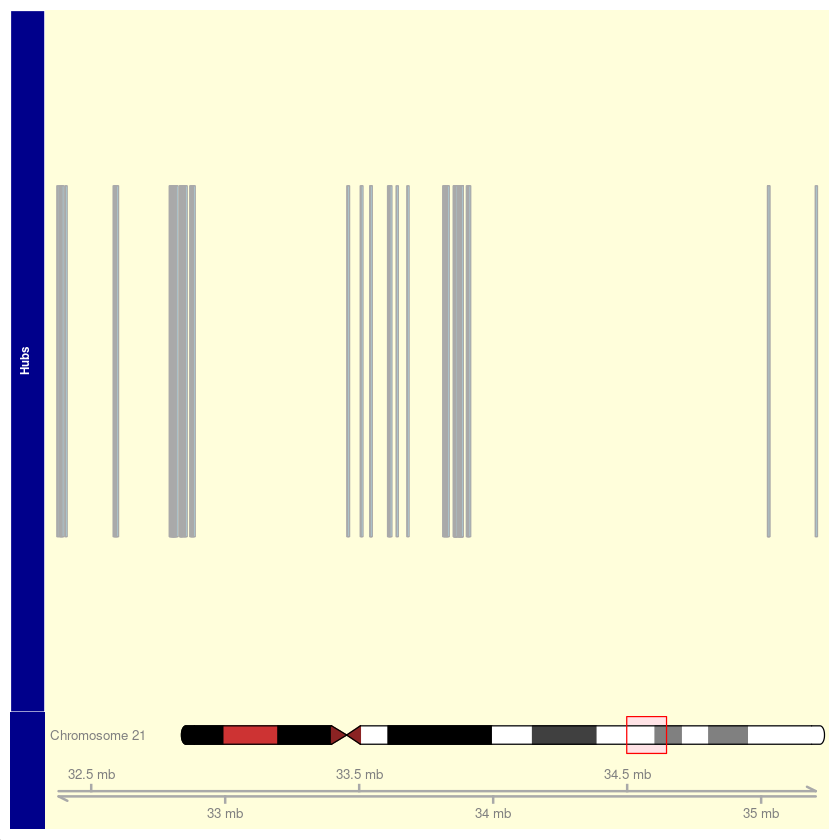

In [50]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = k562gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

So, there is a narrow occurrence of "hubs" in the chromosome 21, as seen above. The specific locations are given below.

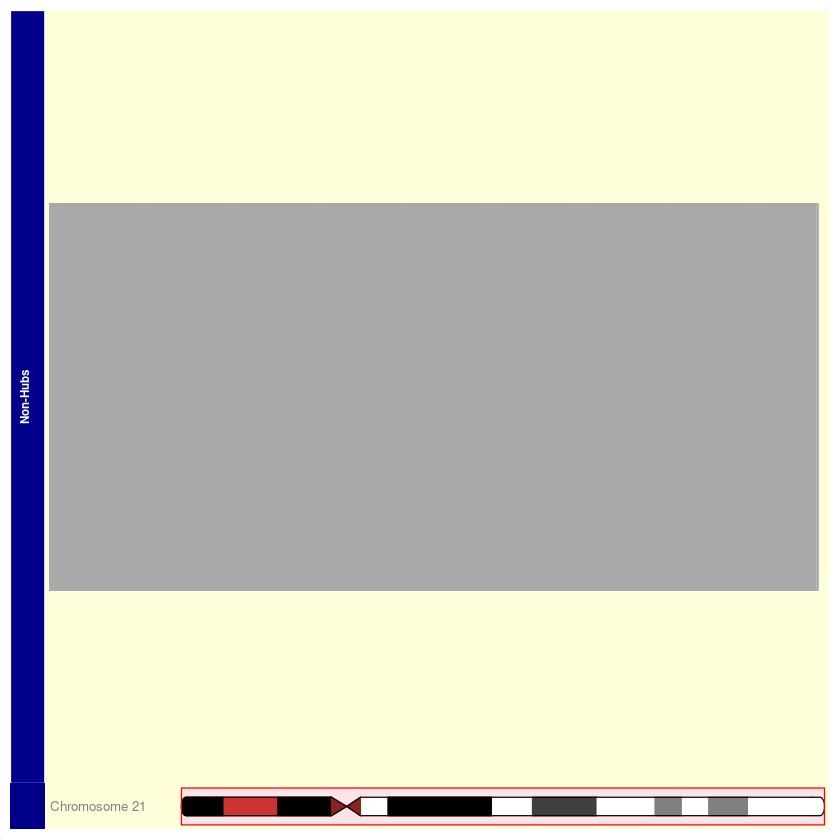

In [51]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = k562gregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

We can observe that the Non-Hubs are pretty evenly distributed throughout the chromosome.In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results.  

In [52]:
k562gregPredicted <- cbind(k562gregStandardRegionsClass, k562gregModelPredictionsProbs)
names(k562gregPredicted)[names(k562gregPredicted)=="k562gregModelPredictionsProbs"] <- "Prediction"
k562gregPredicted$Prediction <- ifelse(k562gregPredicted$Prediction == 1, "Hub", "Non-Hub")            

Let us see if the classifier predictions match with the original results.

In [53]:
k562gregChr21PredicitedHub <- k562gregPredicted[k562gregPredicted$chr=="chr21" & k562gregPredicted$Prediction =="Hub", ]

Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

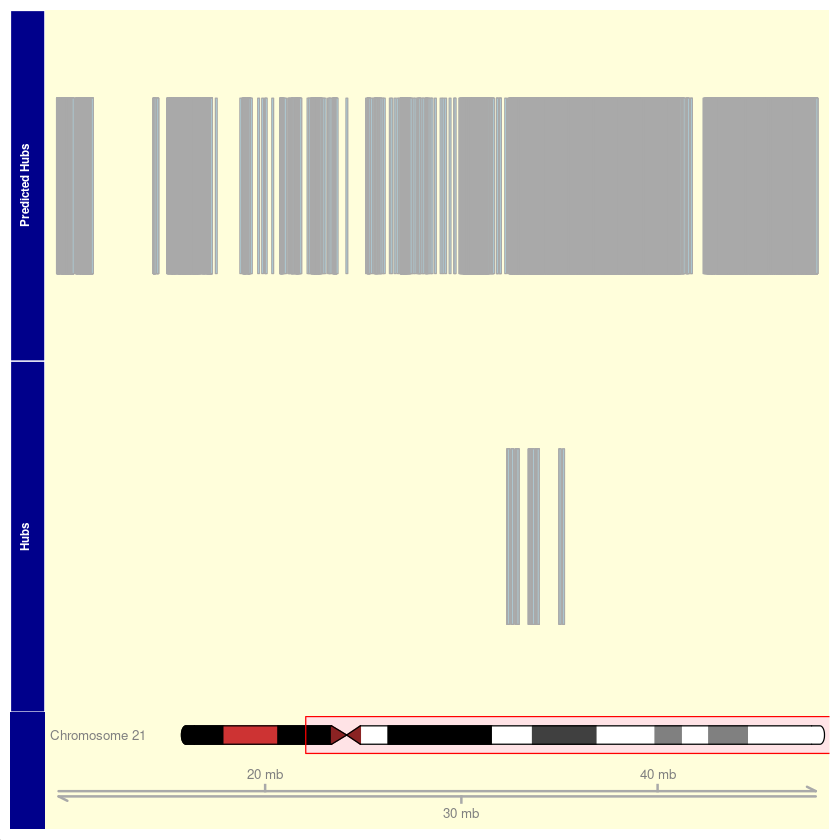

In [54]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = k562gregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = k562gregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In [55]:
truePositives <- k562gregPredicted[k562gregPredicted$Class == k562gregPredicted$Prediction, ]

As we close, we'll save the optimal model and true positive genomic regions (hubs) as explicit R data objects, in order to recall for later use.

In [56]:
## Saving relevant files

save(k562modelUnder1, file = "./optimalModels/k562modelLR") # optimal model
write.table(truePositives, file = "./truePositives/k562LR.txt", quote = FALSE) # true positives: precicted ~ original
write.table(underTrain, file = "./buildData/optimalModelTrainK562.txt", quote = FALSE) # data used to train model
write.table(test, file = "./buildData/optimalModelTestK562.txt", quote = FALSE) # data used to test model

### Conclusion

We see that the best performing model isn't just graded by its accuracy (which is corresponding to the current state of class distribution), but by how well it is able to differentiate between the negative and positive classes. Considering the same as premise, we identified that the following is the best performing model with related attributes.

| Best Model | Accuracy | Sensitivity | Specificity | Remark
| --- | --- | --- | --- | ---
| k562modelUnder1 | 72.14441 % | 72.1866 % | 55.47826 % | Good


### <a id=link13>7. Session Information </a>

In [57]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.30.3          GenomicRanges_1.38.0 GenomeInfoDb_1.22.1 
 [4] IRanges_2.20.2       S4Vectors_0.24.4     BiocGenerics_0.32.0 
 [7] ROCR_1.0-11          DMwR_0.4.1           ROSE_0.0-3          
[10] e1071_1.7-3          caret_6.0-86         rms_6.0-1           
[13] SparseM_1.78         H